# RNN & Word Embeddings for SEC Filings to Predict Returns

RNNs are commonly applied to various natural language processing tasks. We've already encountered sentiment analysis using text data in part three of this book.

We are now going to apply an RNN model to SEC filings to learn custom word embeddings (see Chapter 16) and predict the returns over the week after the filing date.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from time import time
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import yfinance as yf

from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GRU, Bidirectional,
                                     Embedding, BatchNormalization, Dropout)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [6]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

In [7]:
deciles = np.arange(.1, 1, .1).round(1)

## Get stock price data

### Paths

In [8]:
data_path = Path('..', 'data', 'sec-filings')

In [9]:
results_path = Path('results', 'sec-filings')

selected_section_path = results_path / 'ngrams_1'
ngram_path = results_path / 'ngrams'
vector_path = results_path / 'vectors'

for path in [vector_path, selected_section_path, ngram_path]:
    if not path.exists():
        path.mkdir(parents=True)

### Get filing info

In [10]:
filing_index = (pd.read_csv(data_path / 'filing_index.csv',
                            parse_dates=['DATE_FILED'])
                .rename(columns=str.lower))
filing_index.index += 1

In [11]:
filing_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 1 to 22631
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cik           22631 non-null  int64         
 1   company_name  22631 non-null  object        
 2   form_type     22631 non-null  object        
 3   date_filed    22631 non-null  datetime64[ns]
 4   edgar_link    22631 non-null  object        
 5   quarter       22631 non-null  int64         
 6   ticker        22631 non-null  object        
 7   sic           22461 non-null  object        
 8   exchange      20619 non-null  object        
 9   hits          22555 non-null  object        
 10  year          22631 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


In [12]:
filing_index.head()

,cik,company_name,form_type,date_filed,edgar_link,quarter,ticker,sic,exchange,hits,year
1,1000180,SANDISK CORP,10-K,2013-02-19,edgar/data/1000180/0001000180-13-000009.txt,1,SNDK,3572,NASDAQ,3,2013
2,1000209,MEDALLION FINANCIAL CORP,10-K,2013-03-13,edgar/data/1000209/0001193125-13-103504.txt,1,TAXI,6199,NASDAQ,0,2013
3,1000228,HENRY SCHEIN INC,10-K,2013-02-13,edgar/data/1000228/0001000228-13-000010.txt,1,HSIC,5047,NASDAQ,3,2013
4,1000229,CORE LABORATORIES N V,10-K,2013-02-19,edgar/data/1000229/0001000229-13-000009.txt,1,CLB,1389,NYSE,2,2013
5,1000232,KENTUCKY BANCSHARES INC KY,10-K,2013-03-28,edgar/data/1000232/0001104659-13-025094.txt,1,KTYB,6022,OTC,0,2013


In [13]:
filing_index.ticker.nunique()

6630

In [14]:
filing_index.date_filed.describe()

count                   22631
unique                    980
top       2014-03-31 00:00:00
freq                      442
first     2013-01-02 00:00:00
last      2016-12-30 00:00:00
Name: date_filed, dtype: object

### Download stock price data using Yfinance

In [ ]:
yf_data, missing = [], []
for i, (symbol, dates) in enumerate(filing_index.groupby('ticker').date_filed, 1):
    
    if i % 250 == 0:
        print(i, len(yf_data), len(set(missing)), flush=True)
    
    ticker = yf.Ticker(symbol)
    for filing, date in dates.to_dict().items():
        start = date - timedelta(days=93)
        end = date + timedelta(days=31)
        df = ticker.history(start=start, end=end)
        if df.empty:
            missing.append(symbol)
        else:
            yf_data.append(df.assign(ticker=symbol, filing=filing))

In [ ]:
yf_data = pd.concat(yf_data).rename(columns=str.lower)

In [ ]:
yf_data.to_hdf(results_path / 'sec_returns.h5', 'data/yfinance')

In [ ]:
yf_data = pd.read_hdf(results_path / 'sec_returns.h5', 'data/yfinance')

In [ ]:
yf_data.ticker.nunique()

In [ ]:
yf_data.info()

### Get (some) missing prices from Quandl

In [ ]:
to_do = (filing_index.loc[~filing_index.ticker.isin(yf_data.ticker.unique()), 
                          ['ticker', 'date_filed']])

In [ ]:
to_do.date_filed.min()

In [ ]:
quandl_tickers = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
                  .loc[idx['2012':, :], :]
                  .index.unique('ticker'))
quandl_tickers = list(set(quandl_tickers).intersection(set(to_do.ticker)))

In [ ]:
len(quandl_tickers)

In [ ]:
to_do = filing_index.loc[filing_index.ticker.isin(quandl_tickers), ['ticker', 'date_filed']]

In [ ]:
to_do.info()

In [ ]:
ohlcv = ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']

In [ ]:
quandl = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
          .loc[idx['2012': , quandl_tickers], ohlcv]
          .rename(columns=lambda x: x.replace('adj_', '')))

In [ ]:
quandl.info()

In [ ]:
quandl_data = []
for i, (symbol, dates) in enumerate(to_do.groupby('ticker').date_filed, 1):
    if i % 100 == 0:
        print(i, end=' ', flush=True)
    for filing, date in dates.to_dict().items():
        start = date - timedelta(days=93)
        end = date + timedelta(days=31)
        quandl_data.append(quandl.loc[idx[start:end, symbol], :].reset_index('ticker').assign(filing=filing))
quandl_data = pd.concat(quandl_data)

In [ ]:
quandl_data.to_hdf(results_path / 'sec_returns.h5', 'data/quandl')

### Combine, clean and persist

In [ ]:
data = (pd.read_hdf(results_path / 'sec_returns.h5', 'data/yfinance')
        .drop(['dividends', 'stock splits'], axis=1)
        .append(pd.read_hdf(results_path / 'sec_returns.h5',
                            'data/quandl')))

In [ ]:
data = data.loc[:, ['filing', 'ticker', 'open', 'high', 'low', 'close', 'volume']]

In [ ]:
data.info()

In [ ]:
data[['filing', 'ticker']].nunique()

In [ ]:
data.to_hdf(results_path / 'sec_returns.h5', 'prices')

## Copy filings with stock price data

In [16]:
data = pd.read_hdf(results_path / 'sec_returns.h5', 'prices')

In [17]:
filings_with_data = data.filing.unique()
len(filings_with_data)

16758

### Remove short and long sentences

In [18]:
min_sentence_length = 5
max_sentence_length = 50

In [19]:
sent_length = Counter()
for i, idx in enumerate(filings_with_data, 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    text = pd.read_csv(data_path / 'selected_sections' / f'{idx}.csv').text
    sent_length.update(text.str.split().str.len().tolist())
    text = text[text.str.split().str.len().between(min_sentence_length, max_sentence_length)]
    text = '\n'.join(text.tolist())
    with (selected_section_path / f'{idx}.txt').open('w') as f:
        f.write(text)

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 

In [20]:
sent_length = pd.Series(dict(sent_length.most_common()))

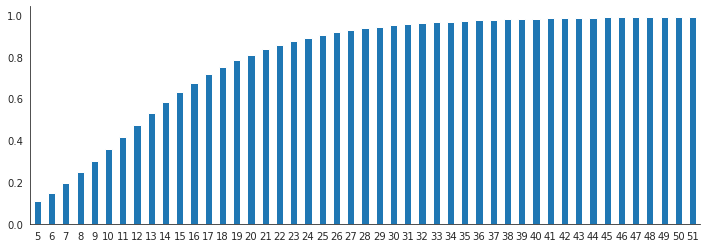

In [21]:
with sns.axes_style("white"):
    sent_length.sort_index().cumsum().div(sent_length.sum()).loc[5:51].plot.bar(figsize=(12, 4), rot=0)
    sns.despine();

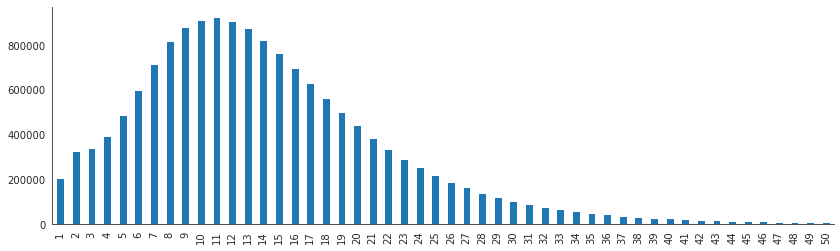

In [22]:
with sns.axes_style("white"):
    sent_length.sort_index().loc[:50].plot.bar(figsize=(14, 4))
    sns.despine();

### Create bi- and trigrams

Combine all filings

In [23]:
files = selected_section_path.glob('*.txt')
texts = [f.read_text() for f in files]
unigrams = ngram_path / 'ngrams_1.txt'
unigrams.write_text('\n'.join(texts))

1827326308

In [24]:
texts = unigrams.read_text()

In [ ]:
n_grams = []
start = time()
for i, n in enumerate([2, 3]):
    sentences = LineSentence(ngram_path / f'ngrams_{n-1}.txt')
    phrases = Phrases(sentences=sentences,
                      min_count=25,  # ignore terms with a lower count
                      threshold=0.5,  # accept phrases with higher score
                      max_vocab_size=4000000,  # prune of less common words to limit memory use
                      delimiter=b'_',  # how to join ngram tokens
                      scoring='npmi')

    s = pd.DataFrame([[k.decode('utf-8'), v] for k, v in phrases.export_phrases(sentences)], 
                     columns=['phrase', 'score']).assign(length=n)

    n_grams.append(s.groupby('phrase').score.agg(['mean', 'size']))
    print(n_grams[-1].nlargest(5, columns='size'))
    
    grams = Phraser(phrases)
    sentences = grams[sentences]
    (ngram_path / f'ngrams_{n}.txt').write_text('\n'.join([' '.join(s) for s in sentences]))
    
    src_dir = results_path / f'ngrams_{n-1}'
    target_dir = results_path / f'ngrams_{n}'
    if not target_dir.exists():
        target_dir.mkdir()
    
    for f in src_dir.glob('*.txt'):
        text = LineSentence(f)
        text = grams[text]
        (target_dir / f'{f.stem}.txt').write_text('\n'.join([' '.join(s) for s in text]))
    print('\n\tDuration: ', format_time(time() - start))

n_grams = pd.concat(n_grams).sort_values('size', ascending=False)          
n_grams.to_parquet(results_path / 'ngrams.parquet')

In [ ]:
n_grams.groupby(n_grams.index.str.replace('_', ' ').str.count(' ')).size()

### Convert filings to integer sequences based on token count

In [ ]:
sentences = (ngram_path / 'ngrams_3.txt').read_text().split('\n')

In [ ]:
n = len(sentences)

In [ ]:
token_cnt = Counter()
for i, sentence in enumerate(sentences, 1):
    if i % 500000 == 0:
        print(f'{i/n:.1%}', end=' ', flush=True)
    token_cnt.update(sentence.split())
token_cnt = pd.Series(dict(token_cnt.most_common()))
token_cnt = token_cnt.reset_index()
token_cnt.columns = ['token', 'n']  

In [ ]:
token_cnt.to_parquet(results_path / 'token_cnt')

In [ ]:
token_cnt.n.describe(deciles).apply(lambda x: f'{x:,.0f}')

In [ ]:
token_cnt.info()

In [ ]:
token_cnt.nlargest(10, columns='n')

In [ ]:
token_cnt.sort_values(by=['n', 'token'], ascending=[False, True]).head()

In [ ]:
token_by_freq = token_cnt.sort_values(by=['n', 'token'], ascending=[False, True]).token
token2id = {token: i for i, token in enumerate(token_by_freq, 3)}

In [ ]:
len(token2id)

In [ ]:
for token, i in token2id.items():
    print(token, i)
    break

In [ ]:
def generate_sequences(min_len=100, max_len=20000, num_words=25000, oov_char=2):
    if not vector_path.exists():
        vector_path.mkdir()
    seq_length = {}
    skipped = 0
    for i, f in enumerate((results_path / 'ngrams_3').glob('*.txt'), 1):
        file_id = f.stem
        text = f.read_text().split('\n')
        vector = [token2id[token] if token2id[token] + 2 < num_words else oov_char 
                  for line in text 
                  for token in line.split()]
        vector = vector[:max_len]
        if len(vector) < min_len:
            skipped += 1
            continue
        seq_length[int(file_id)] = len(vector)
        np.save(vector_path / f'{file_id}.npy', np.array(vector))
    seq_length = pd.Series(seq_length)
    return seq_length

In [ ]:
seq_length = generate_sequences()

In [ ]:
pd.Series(seq_length).to_csv(results_path / 'seq_length.csv')

In [ ]:
seq_length.describe(deciles)

In [ ]:
seq_length.sum()

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(18,5))
token_cnt.n.plot(logy=True, logx=True, ax=axes[0], title='Token Frequency (log-log scale)')
sent_length.sort_index().loc[:50].plot.bar(ax=axes[1], rot=0, title='Sentence Length')

n=5
ticks = axes[1].xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in axes[1].xaxis.get_ticklabels()]
axes[1].xaxis.set_ticks(ticks[n-1::n])
axes[1].xaxis.set_ticklabels(ticklabels[n-1::n])
axes[1].set_xlabel('Sentence Length')

sns.distplot(seq_length, ax=axes[2], bins=50)
axes[0].set_ylabel('Token Frequency')
axes[0].set_xlabel('Token ID')

axes[2].set_xlabel('# Words per Filing')
axes[2].set_title('Filing Length Distribution')

fig.suptitle('Corpus Stats', fontsize=13)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'sec_seq_len', dpi=300);

In [ ]:
files = vector_path.glob('*.npy')
filings = sorted([int(f.stem) for f in files])

## Prepare Model Data

### Create weekly forward returns

In [ ]:
prices = pd.read_hdf(results_path / 'sec_returns.h5', 'prices')
prices.info()

In [ ]:
fwd_return = {}
for filing in filings:
    date_filed = filing_index.at[filing, 'date_filed']
    price_data = prices[prices.filing==filing].close.sort_index()
    
    try:
        r = (price_data
             .pct_change(periods=5)
             .shift(-5)
             .loc[:date_filed]
             .iloc[-1])
    except:
        continue
    if not np.isnan(r) and -.5 < r < 1:
        fwd_return[filing] = r

In [ ]:
len(fwd_return)

### Combine returns with filing data

In [ ]:
y, X = [], []
for filing_id, fwd_ret in fwd_return.items():
    X.append(np.load(vector_path / f'{filing_id}.npy') + 2)
    y.append(fwd_ret)
y = np.array(y)

In [ ]:
len(y), len(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

### Pad sequences

In the second step, we convert the lists of integers into fixed-size arrays that we can stack and provide as input to our RNN. The pad_sequence function produces arrays of equal length, truncated, and padded to conform to maxlen, as follows:

In [ ]:
maxlen = 20000

In [ ]:
X_train = pad_sequences(X_train, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test = pad_sequences(X_test, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

In [ ]:
X_train.shape, X_test.shape

## Define Model Architecture

In [ ]:
K.clear_session()

Now we can define our RNN architecture. The first layer learns the word embeddings. We define the embedding dimension as previously using the input_dim keyword to set the number of tokens that we need to embed, the output_dim keyword, which defines the size of each embedding, and how long each input sequence is going to be.

In [ ]:
embedding_size = 100

Note that we are using GRUs this time, which train faster and perform better on smaller data. We are also using dropout for regularization, as follows:

In [ ]:
input_dim = X_train.max() + 1

In [ ]:
rnn = Sequential([
    Embedding(input_dim=input_dim, 
              output_dim=embedding_size, 
              input_length=maxlen,
             name='EMB'),
    BatchNormalization(name='BN1'),
    Bidirectional(GRU(32), name='BD1'),
    BatchNormalization(name='BN2'),
    Dropout(.1, name='DO1'),
    Dense(5, name='D'),
    Dense(1, activation='linear', name='OUT')
])

The resulting model has over 2 million parameters.

In [ ]:
rnn.summary()

In [ ]:
rnn.compile(loss='mse', 
            optimizer='Adam',
            metrics=[RootMeanSquaredError(name='RMSE'),
                     MeanAbsoluteError(name='MAE')])

## Train model

In [ ]:
early_stopping = EarlyStopping(monitor='val_MAE', 
                               patience=5,
                               restore_best_weights=True)

Training stops after eight epochs and we recover the weights for the best models to find a high test AUC of 0.9346:

In [ ]:
training = rnn.fit(X_train,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping],
                   verbose=1)

## Evaluate the Results

In [ ]:
df = pd.DataFrame(training.history)
df.to_csv(results_path / 'rnn_sec.csv', index=False)

In [ ]:
df.index += 1

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
df[['RMSE', 'val_RMSE']].rename(columns={'RMSE': 'Training', 
                                         'val_RMSE': 'Validation'}).plot(ax=axes[0], title='Root Mean Squared Error')
df[['MAE', 'val_MAE']].rename(columns={'MAE': 'Training', 
                                         'val_MAE': 'Validation'}).plot(ax=axes[1], title='Mean Absolute Error')
for i in [0, 1]:
    axes[i].set_xlim(1, 10)
    axes[i].set_xlabel('Epoch')
fig.tight_layout()
fig.savefig(results_path / 'sec_cv_performance', dpi=300);

In [ ]:
y_score = rnn.predict(X_test)

In [ ]:
rho, p = spearmanr(y_score.squeeze(), y_test)

In [ ]:
print(f'{rho*100:.2f} ({p:.2%})')

In [ ]:
g = sns.jointplot(y_score.squeeze(), y_test, kind='reg')
g.annotate(spearmanr);